# Create the graph based on two separate masks

In [7]:
import pandas as pd
from scipy.sparse.csgraph import connected_components
import preprocessing.preprocessing as pp
import graph_matching.graph_matching as gm

from visualization import graph_to_mesh, mesh_viewer
import numpy as np

nodesFileNerve =  "~/Documents/Intestine/nerve-mask/nodes_nerve_bs2_fh.csv"
edgesFileNerve = "~/Documents/Intestine/nerve-mask/edges_nerve_bs2_fh.csv"

nodesFileLymph =  "~/Documents/Intestine/lymph-mask/nodes_lymph_bs2_fh.csv"
edgesFileLymph = "~/Documents/Intestine/lymph-mask/edges_lymph_bs2_fh.csv"

nodes_n = pd.read_csv(nodesFileNerve, sep = ";", index_col= "id")
edges_n = pd.read_csv(edgesFileNerve, sep = ";", index_col= "id")
nodes_l = pd.read_csv(nodesFileLymph, sep = ";", index_col= "id")
edges_l = pd.read_csv(edgesFileLymph, sep = ";", index_col= "id")


# scaling with the factors provided by luciano
nodes_l = pp.scalePosition(nodes_l, (1.65,1.65,6))
nodes_n = pp.scalePosition(nodes_n, (1.65,1.65,6))


# giving nodes from different files unique names
edges_n, nodes_n = pp.relable_edges_nodes(edges_n, nodes_n, "n")
edges_l, nodes_l = pp.relable_edges_nodes(edges_l, nodes_l, "l")


adjMcsr = pp.distance_based_adjacency(nodes_n, nodes_l, th = 0.03)
num, labels = connected_components(csgraph=adjMcsr, directed = False)
con_comp = pp.connected_components_dict(labels)
rel_comp = pp.relevant_connected_components(con_comp, nodes_n.shape[0], ("n","l"))


contractions = np.sum([len(val) for val in rel_comp.values()])
new_nodes = len(list(rel_comp.keys()))
print("The total number of contracted nodes: " + str(contractions))
print("The total number of resulting nodes: " + str(new_nodes))


reverse_dict= {}
for k, v in rel_comp.items():
    for val in v:
        reverse_dict[val] = k



merged_nodes = pd.concat([nodes_l.loc[:,["pos_x", "pos_y", "pos_z"]], nodes_n.loc[:,["pos_x", "pos_y", "pos_z"]]])
new_nodes = pd.DataFrame(columns=merged_nodes.columns )


# replace the contracted node with new nodes
# the position of the new node is an average of all the previous nodes
for k, valList in rel_comp.items():
    new_nodes.loc[k] = merged_nodes.loc[valList].mean()
    merged_nodes.drop(valList, inplace = True)

# concat the all nodes and the new nodes
merged_nodes = pd.concat([merged_nodes, new_nodes])

# createa a combined edge file
merged_edges = pd.concat([edges_l, edges_n], ignore_index = True)

# change the names of the edges to the new names
for idxE, edge in merged_edges.iterrows():
    if edge["node1id"] in reverse_dict.keys():
        merged_edges.loc[idxE,"node1id"] = reverse_dict[edge["node1id"]]
    if edge["node2id"] in reverse_dict.keys():
        merged_edges.loc[idxE,"node2id"] = reverse_dict[edge["node2id"]]



# make a setting for self loops and isolates 
sloop = 0
isol = 0

# create a new graph based on the old information

G_contract = pp.createGraph(merged_nodes, merged_edges)
G_contract_einf_sep = pp.convertToEinfach(G_contract, self_loops = sloop, isolates = isol)

The total number of contracted nodes: 166
The total number of resulting nodes: 72


# Create the graph based on a combined mask 

In [8]:
nodesFileComb =  "~/Documents/Intestine/combined-mask/nodes_bs2_fh.csv"
edgesFileComb = "~/Documents/Intestine/combined-mask/edges_bs2_fh.csv"

nodes_c = pd.read_csv(nodesFileComb, sep = ";", index_col= "id")
edges_c = pd.read_csv(edgesFileComb, sep = ";", index_col= "id")

print(nodes_c.shape[0])
print(edges_c.shape[0])

# scaling with the factors provided by luciano
nodes_c = pp.scalePosition(nodes_c, (1.65,1.65,6))


G_contract_comb = pp.createGraph(nodes_c, edges_c)
G_contract_einf_comb = pp.convertToEinfach(G_contract_comb, self_loops = sloop, isolates = isol)

3715
5135


# Compare properties of both graphs

In [9]:
pp.graphSummary(G_contract_einf_sep)
pp.graphSummary(G_contract_einf_comb)


***************
Number of Nodes: 3919
Number of Edges: 5040
Number of Connected Components: 41
Number of Self Loops: 0
Number of Isolated Nodes: 0
Average Node Degree: 2.572084715488645
***************
***************
Number of Nodes: 3715
Number of Edges: 5100
Number of Connected Components: 17
Number of Self Loops: 0
Number of Isolated Nodes: 0
Average Node Degree: 2.7456258411843875
***************


In [10]:
import matplotlib.pyplot as plt

# get the neare
res = gm.nearestNeighborNode(G_contract_einf_sep, G_contract_einf_comb)


print("Total Distance: " + str(np.sum(res[0])))
print("Average Distance: " + str(np.mean(res[0])))
print("Median Distance: " + str(np.median(res[0])))


G_contract_einf_comb_relab = gm.nearestNeighborLabeling(G_contract_einf_sep, G_contract_einf_comb)


sep_class_labels = [val[-1] for val in G_contract_einf_sep.nodes()]
comb_class_labels = [val[-1] for val in G_contract_einf_comb_relab.nodes()]

print(np.unique(sep_class_labels, return_counts = True))
print(np.unique(comb_class_labels, return_counts = True))

# what is the avg deviation of the node degree to its match node degree?

sep_node_list = np.array(list(G_contract_einf_sep.nodes()))

deg_dev = []
for i, m_node_idx in enumerate(res[1]):
    deg1 = G_contract_einf_comb.degree[i]
    m_node = sep_node_list[m_node_idx]
    deg2 = G_contract_einf_sep.degree[m_node]
    deg_dev.append(deg1-deg2)


deg_dev_abs = np.abs(deg_dev)
print("Mean difference in the degree of two matche nodes: " + str(np.mean(deg_dev_abs)))
print("Median difference in the degree of two matche nodes: " + str(np.median(deg_dev_abs)))



Total Distance: 83.84533408119222
Average Distance: 0.022569403521182294
Median Distance: 0.015312306018689659
(array(['c', 'l', 'n'], dtype='<U1'), array([  72, 2071, 1776]))
(array(['c', 'l', 'n'], dtype='<U1'), array([  99, 2038, 1578]))
Mean difference in the degree of two matche nodes: 0.3082099596231494
Median difference in the degree of two matche nodes: 0.0


Text(0, 0.5, 'Node Count')

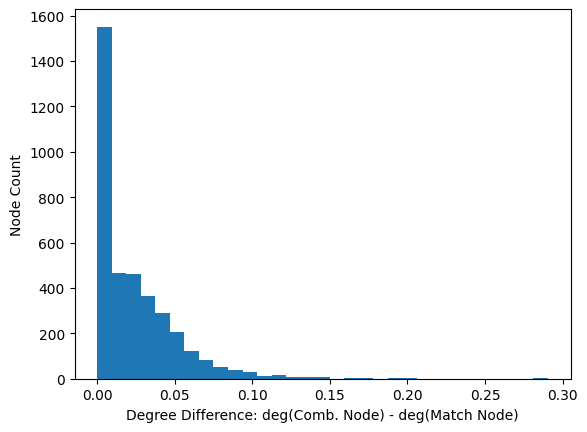

In [11]:
diff, count = np.unique(deg_dev, return_counts = True)

fig = plt.figure()
ax1 = fig.subplots(1)
ax1.hist(res[0], bins = "rice") # 'auto', 'fd', 'doane', 'scott', 'stone', 'rice', 'sturges', or 'sqrt'.
ax1.set_xlabel("Degree Difference: deg(Comb. Node) - deg(Match Node)")
ax1.set_ylabel("Node Count")


Text(0, 0.5, 'Node Count')

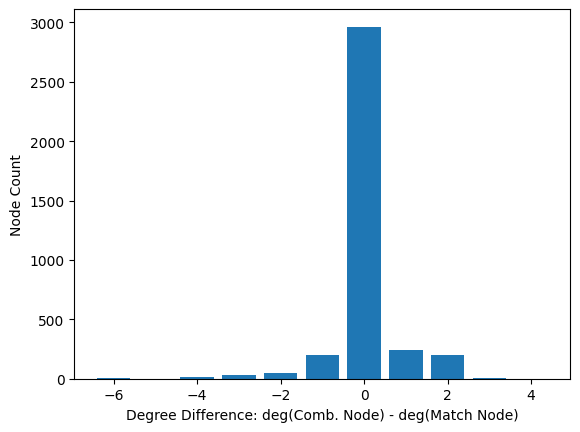

In [12]:
diff, count = np.unique(deg_dev, return_counts = True)

fig = plt.figure()
ax1 = fig.subplots(1)
ax1.bar(diff, count)
ax1.set_xlabel("Degree Difference: deg(Comb. Node) - deg(Match Node)")
ax1.set_ylabel("Node Count")


In [23]:
# converting the graph to a dual graph for classification
import networkx as nx
from torch_geometric.utils.convert import from_networkx
import torch

L = nx.line_graph(G_contract_einf_comb_relab)

feature_dict = {}


for edge in G_contract_einf_comb_relab.edges:
    feature_dict[edge] = G_contract_einf_comb_relab.edges[edge]["x"]

nx.set_node_attributes(L, feature_dict, name="x")



all_nodes = list(L.nodes)
nerve_class = np.array([elem[-1] == "n" for elem in all_nodes])*0
lymph_class = np.array([elem[-1] == "l" for elem in all_nodes])*1
combined_class = np.array([elem[-1] == "c" for elem in all_nodes])*2
class_assign = nerve_class+lymph_class+combined_class


networkDualXG = from_networkx(L)
networkDualXG.y = torch.tensor(class_assign)